In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from typing import List

In [ ]:
def load_csv_data(filepath: str, columns: List[str], transpose: bool, sep: str = ',') -> pd.DataFrame:
    """
    Carrega o dataset EMG e organiza as colunas.

    Args:
        filepath (str): Caminho para o arquivo.
        columns (List[str]): Lista com os nomes das colunas.
        transpose (bool): Transpor o DataFrame.
        sep (str): Separador dos dados.

    Returns:
        pd.DataFrame: DataFrame com dados dos sensores e classes.
    """
    if transpose:
        df: pd.DataFrame = pd.read_csv(filepath, header=None, sep=sep).T
    else:
        df: pd.DataFrame = pd.read_csv(filepath, sep=sep)
    
    df.columns = columns
    
    return df

In [6]:
columns = ["x", "y", "spiral"]

df: pd.DataFrame = load_csv_data(filepath = "../../resources/spiral.csv", columns = columns, transpose = False)

print(df.head())

          x         y  spiral
0  15.07298  -1.56346     1.0
1 -15.43986   0.16502    -1.0
2  -9.26071  12.24981    -1.0
3   7.59201   7.56913    -1.0
4  -2.37130 -10.69521     1.0


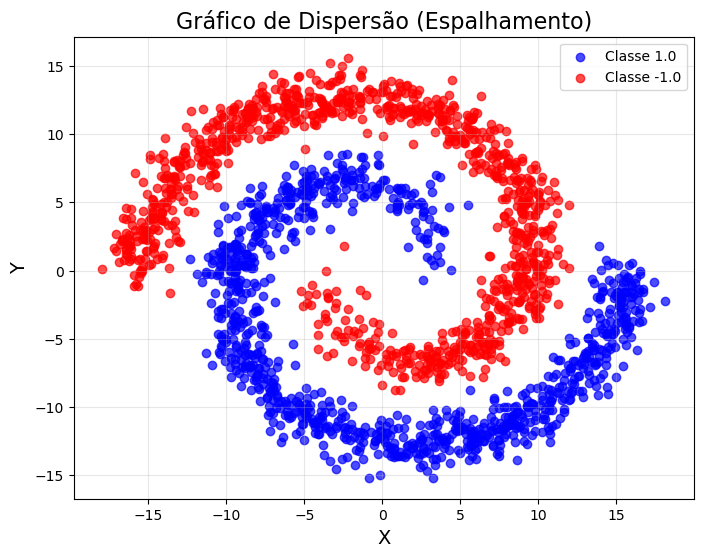

In [7]:
def plot_data(df: pd.DataFrame) -> None:
    plt.figure(figsize=(8, 6))

    plt.scatter(df[df['spiral'] == 1.0]['x'], 
                df[df['spiral'] == 1.0]['y'], 
                color='blue', label='Classe 1.0', alpha=0.7)

    plt.scatter(df[df['spiral'] == -1.0]['x'], 
                df[df['spiral'] == -1.0]['y'], 
                color='red', label='Classe -1.0', alpha=0.7)

    plt.title('Gráfico de Dispersão (Espalhamento)', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)

    plt.legend()

    plt.grid(alpha=0.3)
    plt.show()

plot_data(df)

In [8]:
def prepare_data(
    df: pd.DataFrame, 
    input_columns: List[str], 
    target_column: str,
    transpose: bool = False,
    test_size: float = 0.2, 
    random_state: int = 42
) -> dict:
    """
    Prepara o conjunto de dados para redes neurais, organizando entradas, saídas e divisões.

    Args:
        df (pd.DataFrame): DataFrame contendo o conjunto de dados.
        input_columns (list[str]): Lista com os nomes das colunas de entrada.
        target_column (str): Nome da coluna de saída (rótulos).
        transpose (bool): Transpor o DataFrame. Default é False.
        test_size (float): Proporção do conjunto de teste (0 a 1). Default é 0.2 (20%).
        random_state (int): Semente para reprodutibilidade da divisão. Default é 42.

    Returns:
        dict: Um dicionário contendo os conjuntos organizados:
            - 'X_train': Entradas para treinamento.
            - 'X_test': Entradas para teste.
            - 'Y_train': Rótulos para treinamento.
            - 'Y_test': Rótulos para teste.
    """
    X = df[input_columns].values
    Y = df[target_column].values
    
    if transpose:
        X = X.T
        Y = Y.T
        
        p, N = X.shape
        X = np.concatenate((
            -np.ones((1, N)),
            X
        ))
        
    else:
        N, p = X.shape
        X = np.concatenate((
            -np.ones((N, 1)),
            X
        ), axis = 1)

    return {
        'X': X,
        'Y': Y,
    }

In [9]:
data = prepare_data(
    df, 
    input_columns=["x", "y"], 
    target_column="spiral",
    transpose=True,
    test_size=0.2, 
    random_state=42
)

print(data['X'].shape)
print(data['Y'].shape)

(3, 1999)
(1999,)


In [10]:
def sign(u: float) -> int:
    """
    Função de ativação degrau.

    Args:
        u (float): Soma ponderada.

    Returns:
        int: Saída da função de ativação.
    """
    return 1 if u >= 0 else -1

In [11]:
def simple_perceptron_train(
    X_train: np.ndarray,
    Y_train: np.ndarray,
    epochs: int = 1000,
    learning_rate: float = 0.01,
    w_random: bool = True,
    data_frame: pd.DataFrame = None
) -> np.ndarray:
    """
    Implementa o Perceptron Simples.

    Args:
        X_train (np.ndarray): Entradas de treinamento, com dimensão (p+1, N), incluindo bias.
        Y_train (np.ndarray): Rótulos de treinamento, com dimensão (1, N).
        epochs (int): Número de épocas.
        learning_rate (float): Taxa de aprendizado.
        w_random (bool): Inicializar pesos aleatoriamente (True) ou como zeros (False).

    Returns:
        np.ndarray: Vetor de pesos aprendido, com dimensão (p+1, 1).
    """
    error = True
    p, N = X_train.shape
    
    if w_random:
        W = np.random.random_sample((p, 1)) - 0.5
    else:
        W = np.zeros((p, 1))

    # Configuração inicial do gráfico
    plt.figure(figsize=(8, 6))
    if data_frame is not None:
        plt.scatter(data_frame[data_frame['spiral'] == 1.0]['x'],
                    data_frame[data_frame['spiral'] == 1.0]['y'], 
                    color='blue', label='Classe 1.0', alpha=0.7)
        plt.scatter(data_frame[data_frame['spiral'] == -1.0]['x'], 
                    data_frame[data_frame['spiral'] == -1.0]['y'], 
                    color='red', label='Classe -1.0', alpha=0.7)
    plt.title('Treinamento do Perceptron - Linha de Decisão', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)

    x_axis = np.linspace(-15, 15, 100)

    for epoch in range(epochs):
        if not error:
            break

        error = False  # Reseta o erro antes de cada época
        for t in range(N):
            x_t = X_train[:, t].reshape(p, 1)
            d_t = Y_train[0, t]

            u_t = W.T @ x_t
            y_t = sign(u_t[0, 0])
            e_t = d_t - y_t

            W += (learning_rate * e_t * x_t) / 2

            if y_t != d_t:
                error = True

        # Atualiza a linha de decisão no mesmo gráfico
        if W[2, 0] != 0:
            x2 = -W[1, 0] / W[2, 0] * x_axis + W[0, 0] / W[2, 0]
            x2 = np.nan_to_num(x2)
            plt.plot(x_axis, x2, color='orange', alpha=0.1)

        plt.pause(0.1)  # Pequena pausa para visualização

    # Linha final após o término do treinamento
    if W[2, 0] != 0:
        x2 = -W[1, 0] / W[2, 0] * x_axis + W[0, 0] / W[2, 0]
        x2 = np.nan_to_num(x2)
        plt.plot(x_axis, x2, color='green', linewidth=2)

    plt.show()

    return W

In [12]:
def simple_perceptron_test(
    X_test: np.ndarray,
    W: np.ndarray
) -> np.ndarray:
    """
    Realiza a classificação de amostras desconhecidas usando um perceptron simples.

    Args:
        X_test (np.ndarray): Conjunto de entradas para teste, com dimensão (p+1, M), incluindo bias.
        W (np.ndarray): Vetor de pesos aprendido na fase de treinamento, com dimensão (p+1, 1).

    Returns:
        np.ndarray: Vetor de predições, com dimensão (1, M), onde cada valor é -1 ou 1, 
                    indicando a classe prevista para cada amostra.
    """
    p, M = X_test.shape
    predictions = np.zeros((1, M))

    for t in range(M):
        x_unknown = X_test[:, t].reshape(p, 1)
        
        # Operação de decisão
        u = W.T @ x_unknown
        y = sign(u[0, 0])

        # Classificação
        predictions[0, t] = y

        if y == -1:
            print(f"Amostra {t} pertence à classe A.")
        else:
            print(f"Amostra {t} pertence à classe B.")

    return predictions

          x         y  spiral
0  15.07298  -1.56346     1.0
1 -15.43986   0.16502    -1.0
2  -9.26071  12.24981    -1.0
3   7.59201   7.56913    -1.0
4  -2.37130 -10.69521     1.0


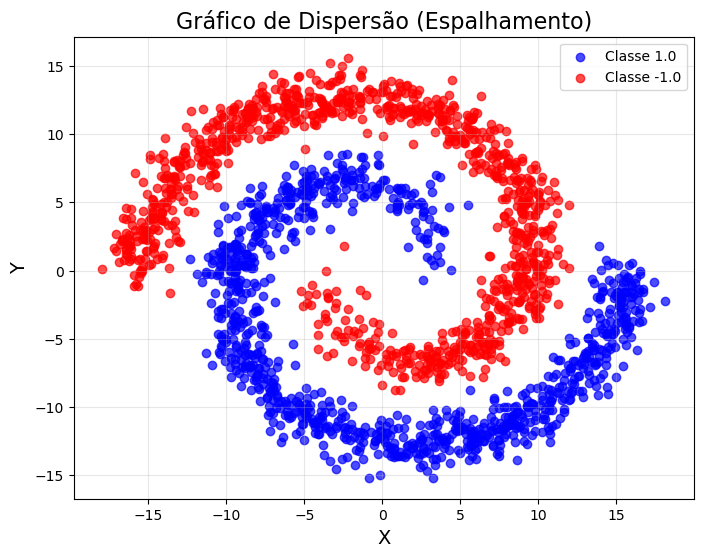

(3, 1999)
(1999,)


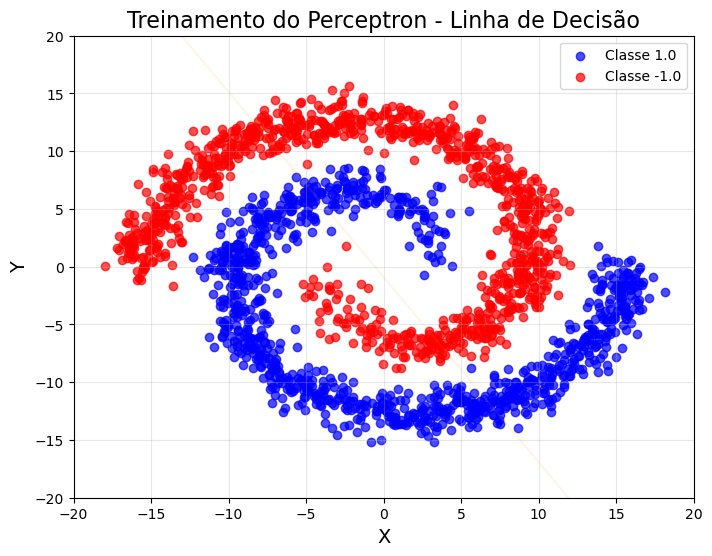

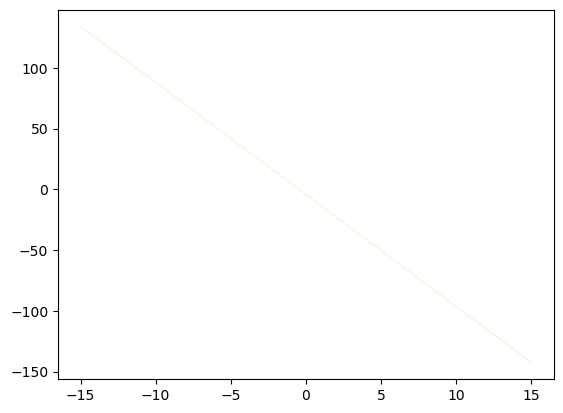

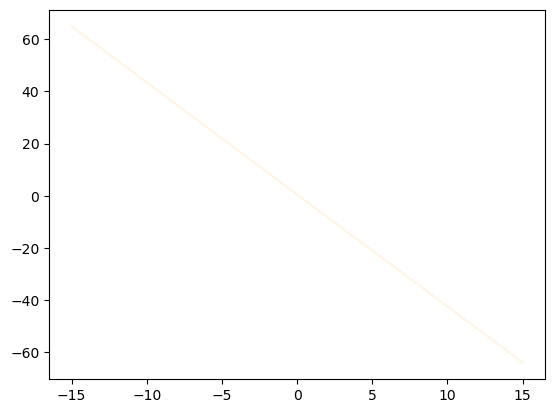

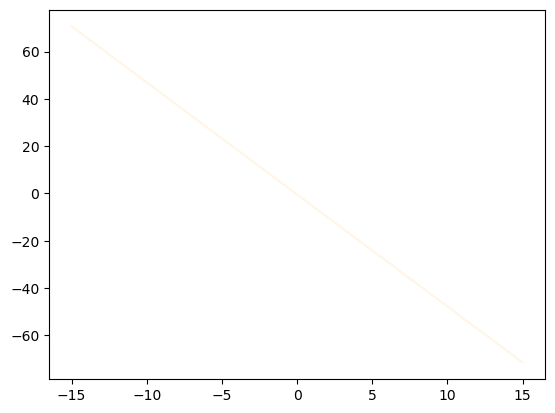

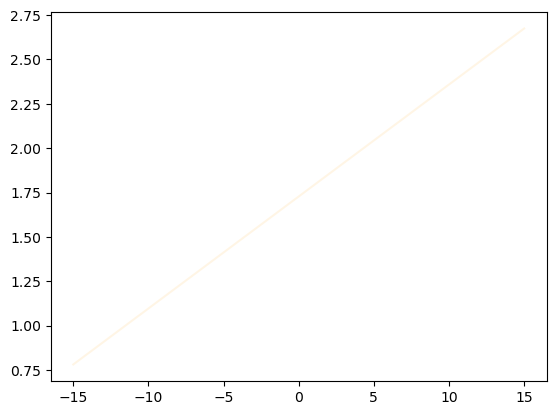

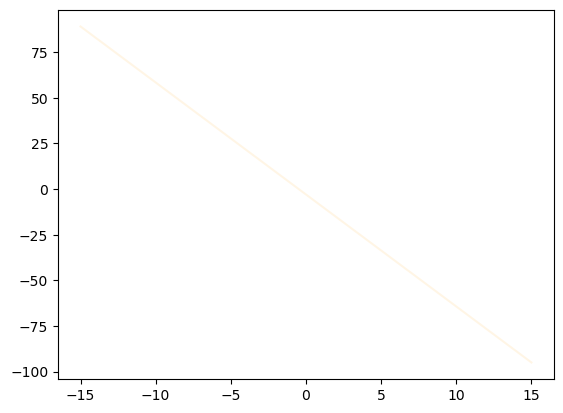

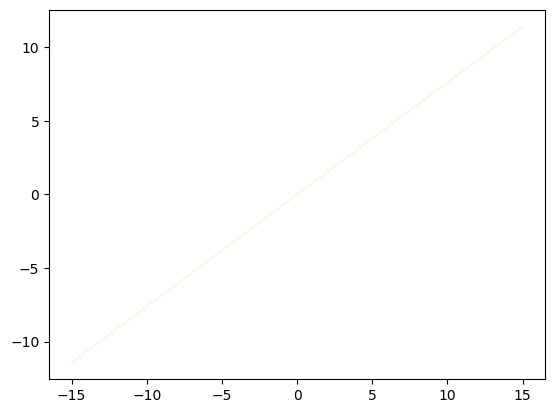

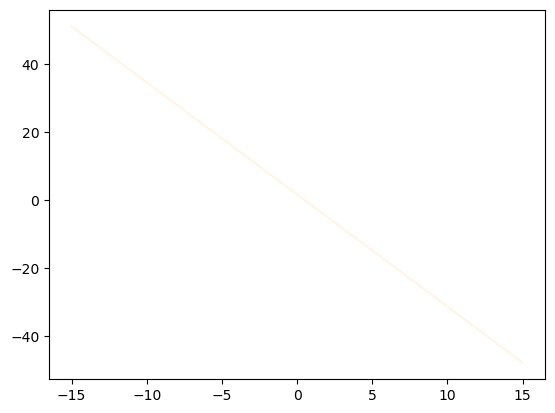

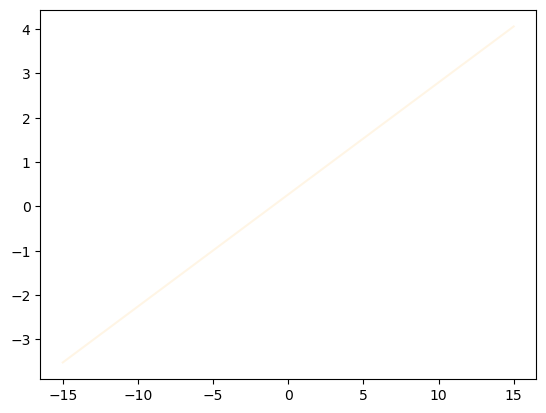

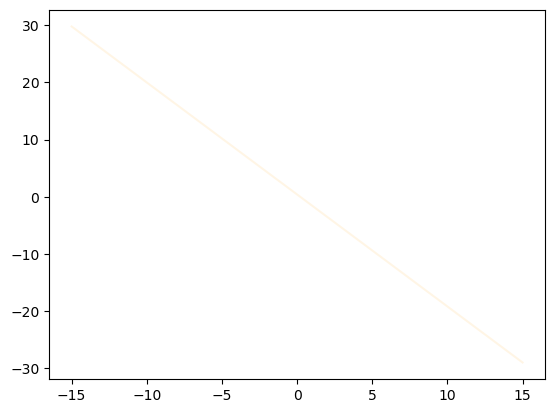

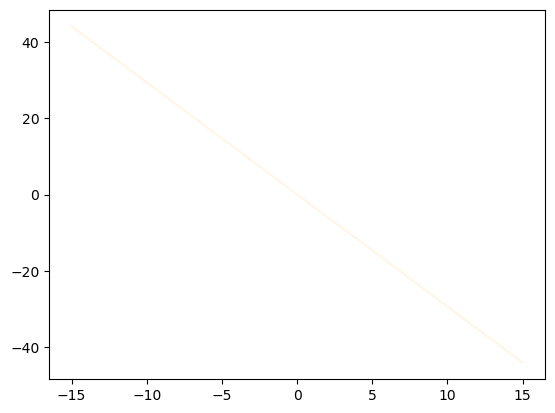

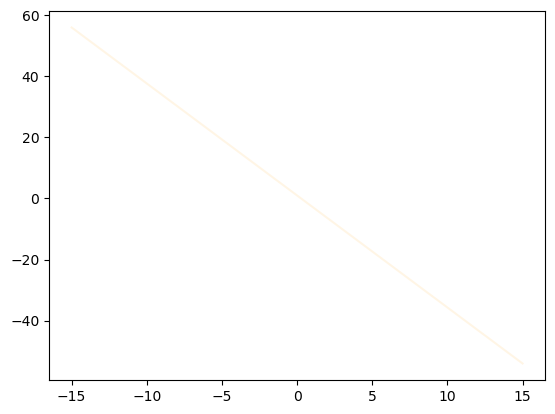

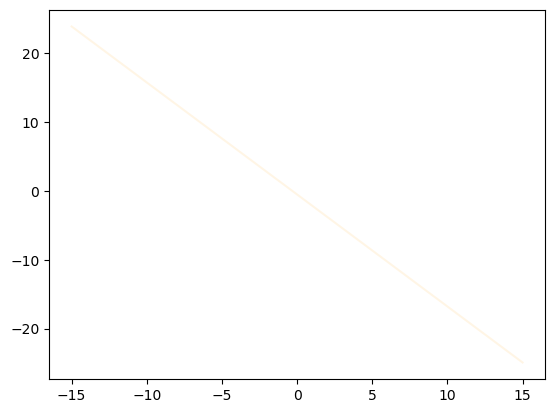

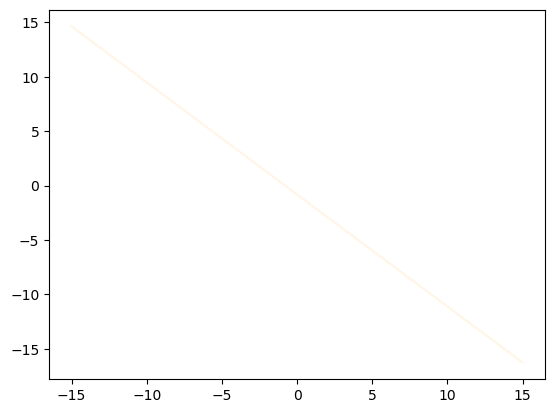

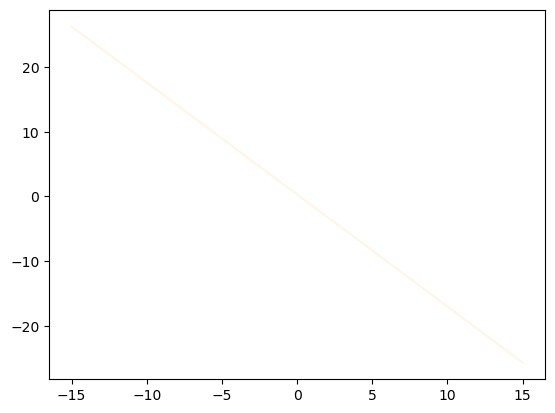

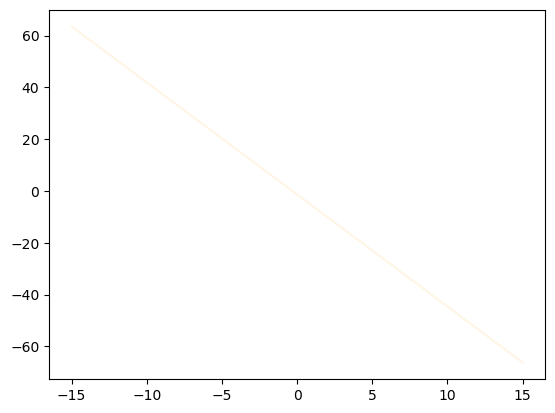

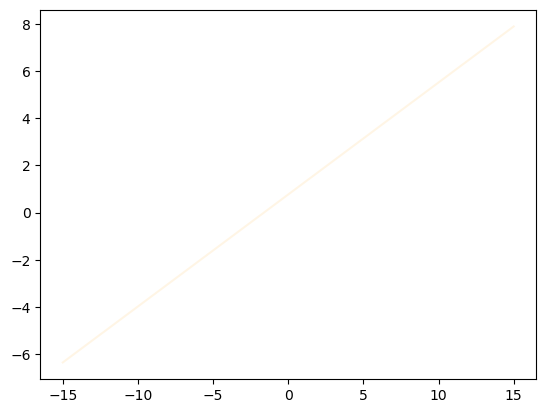

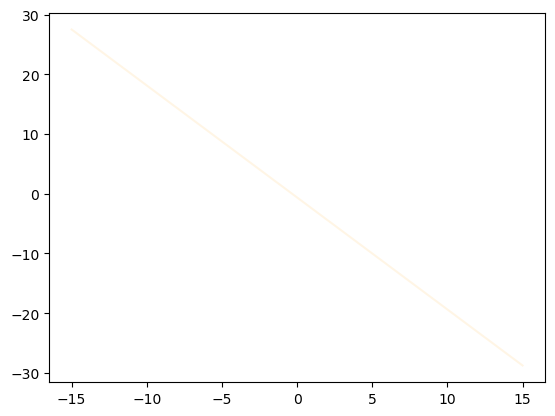

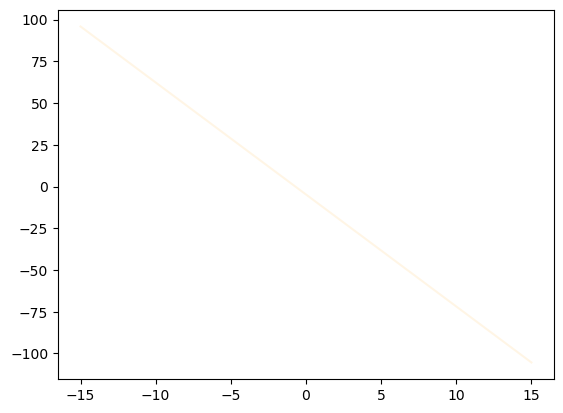

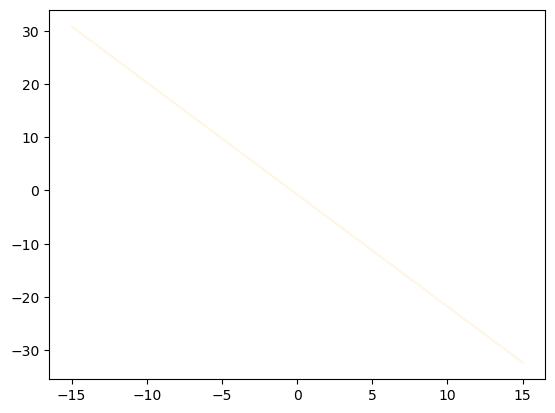

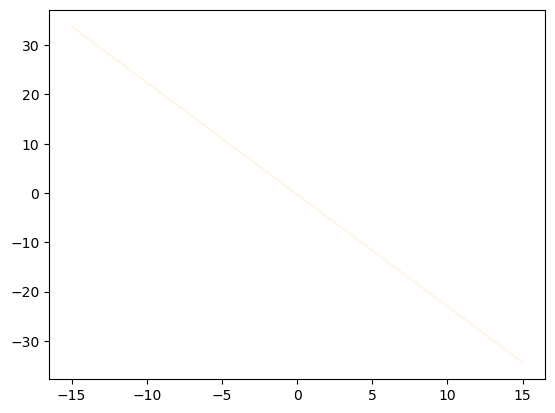

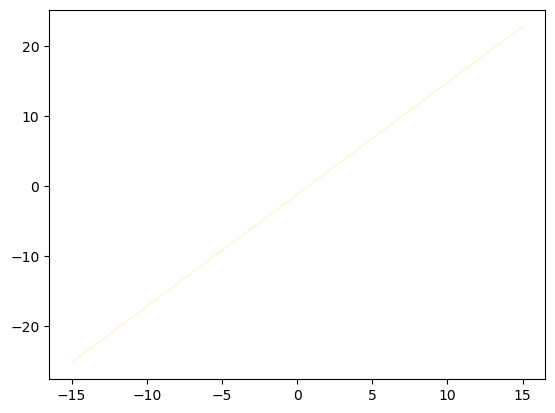

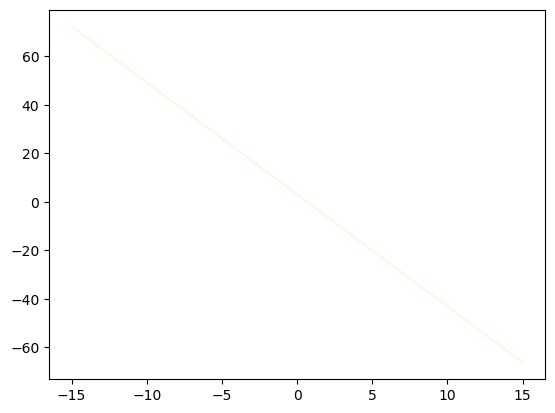

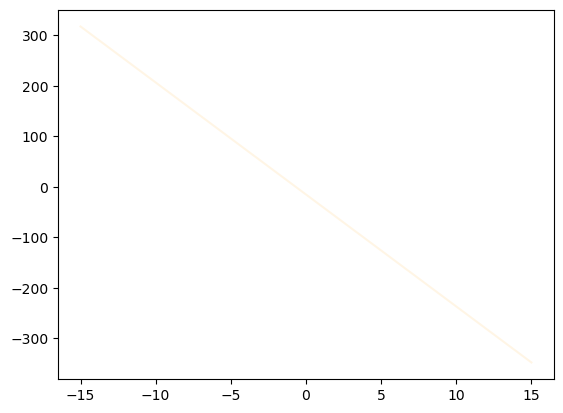

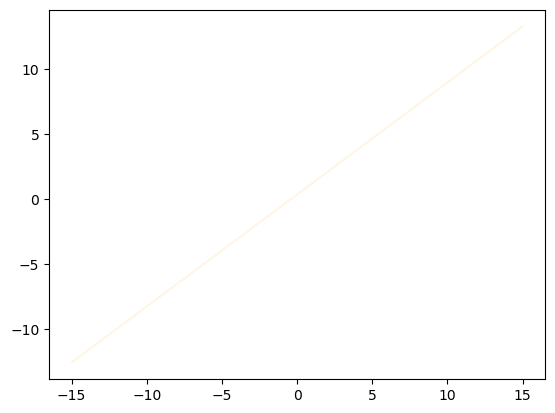

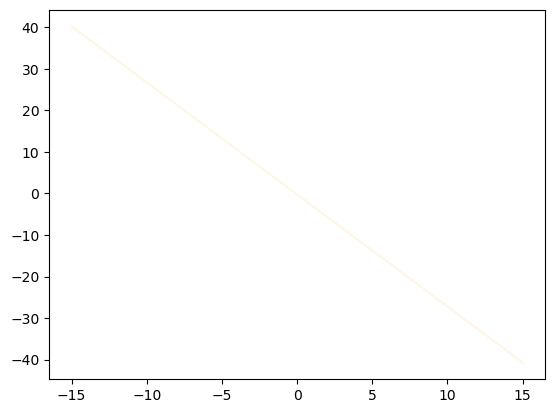

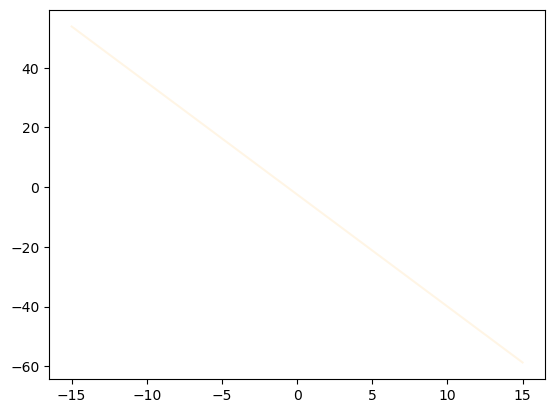

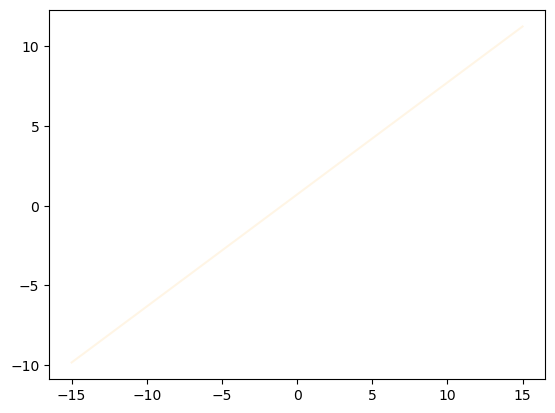

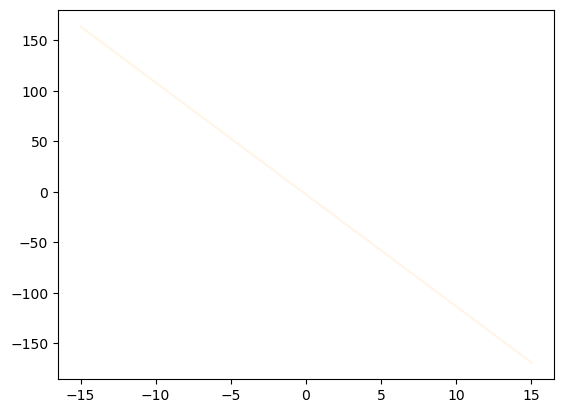

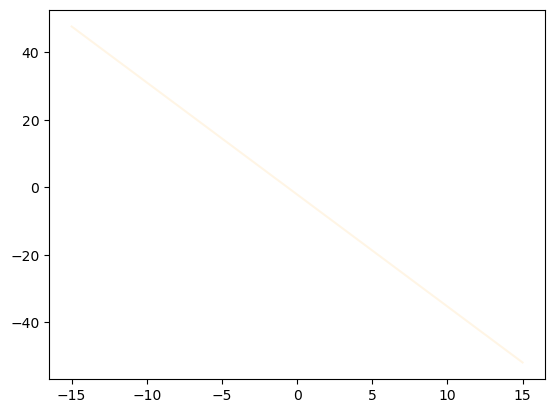

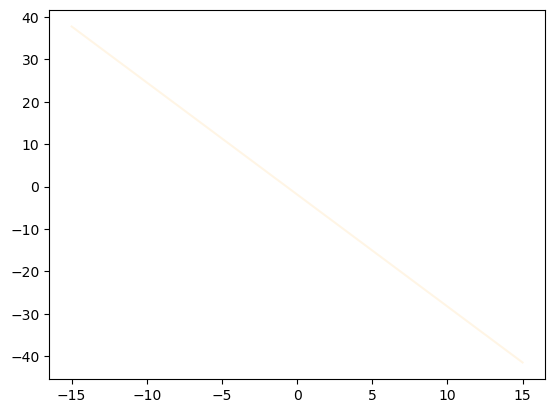

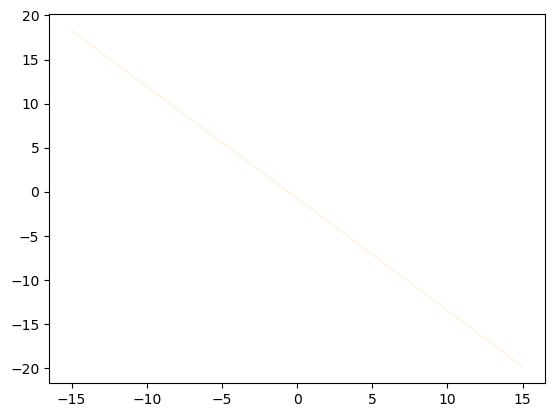

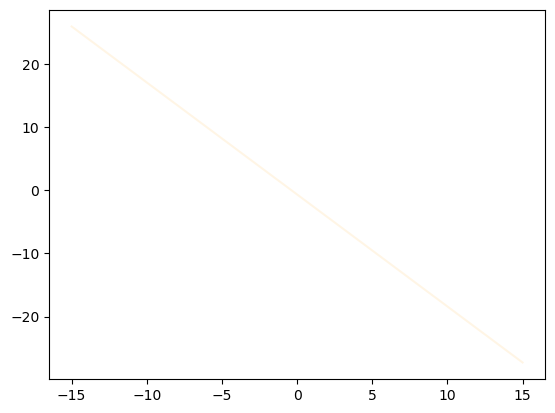

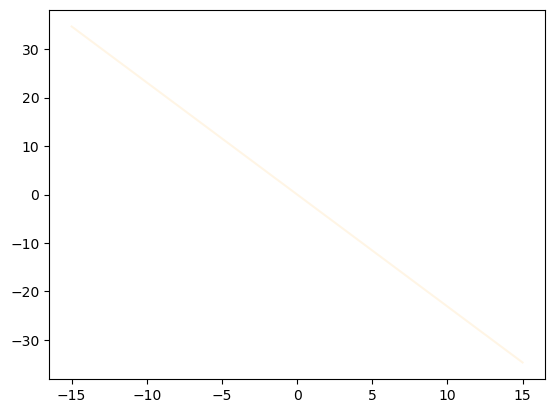

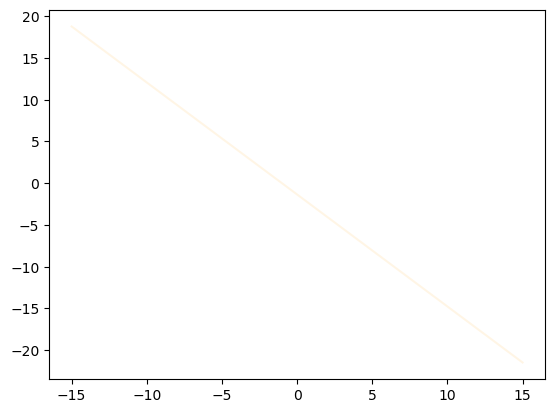

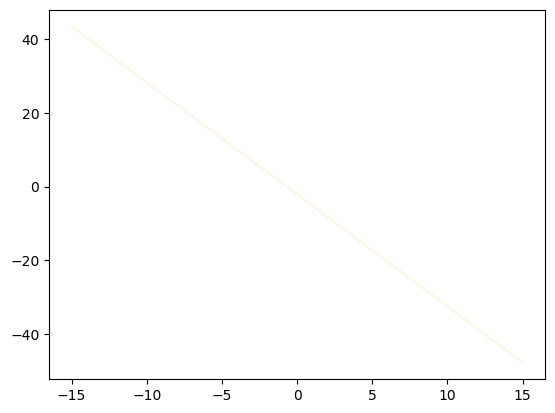

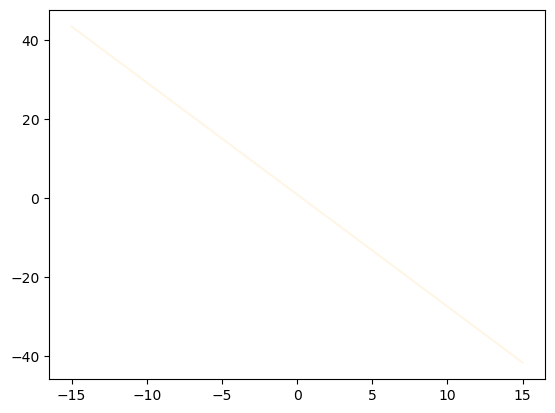

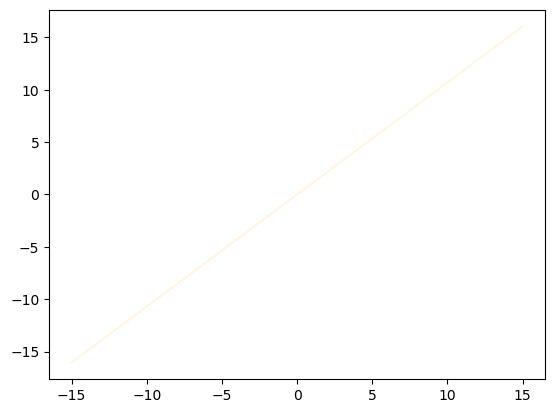

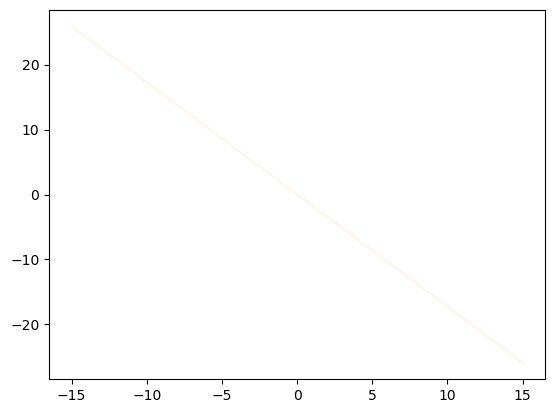

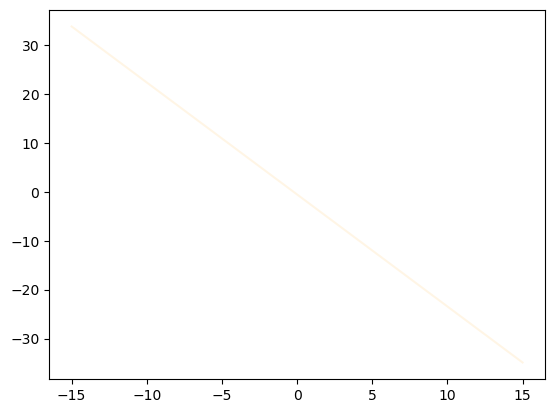

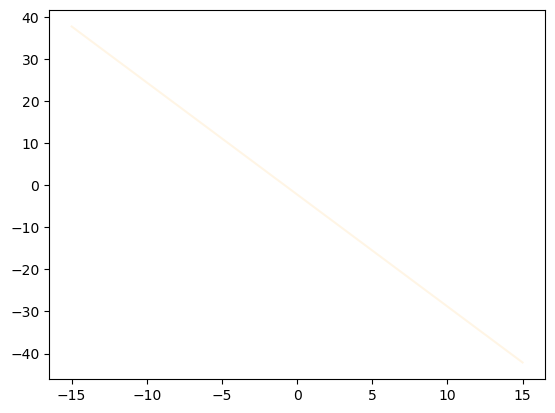

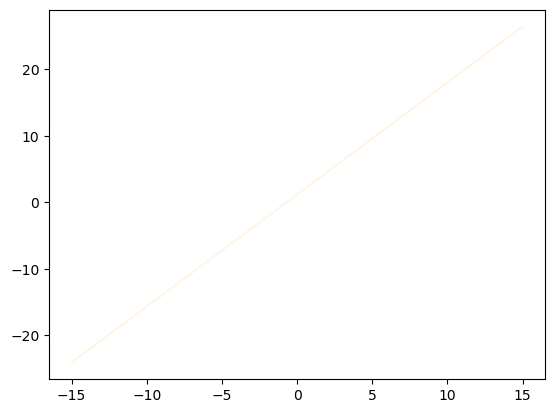

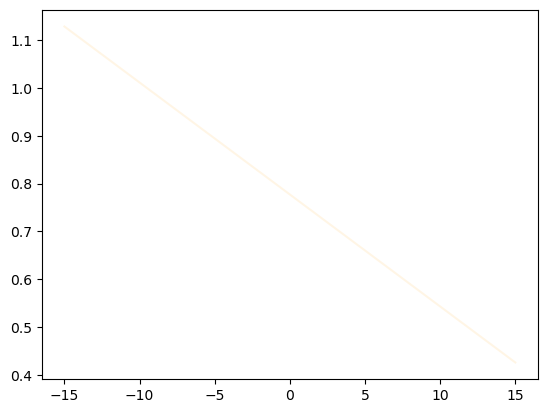

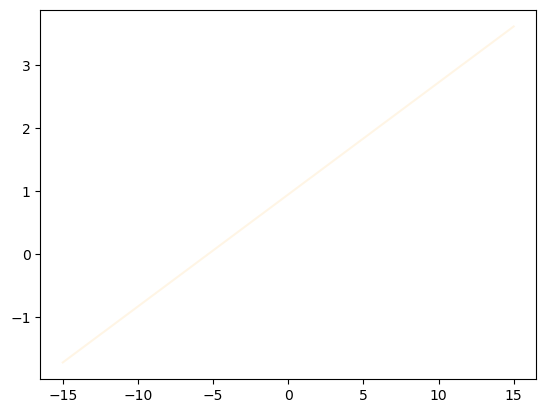

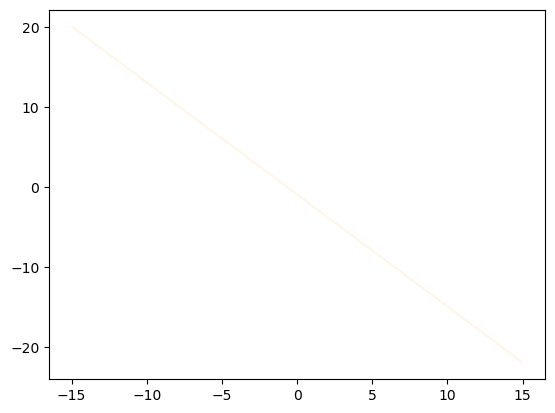

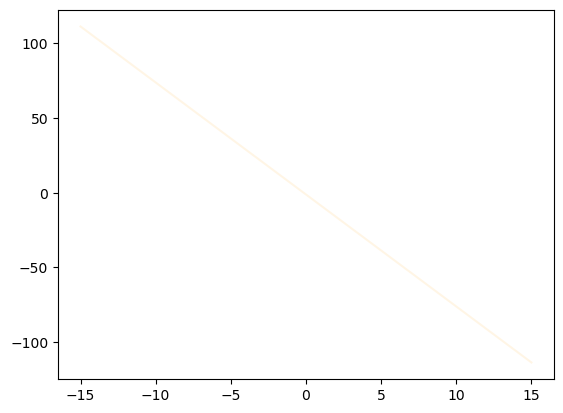

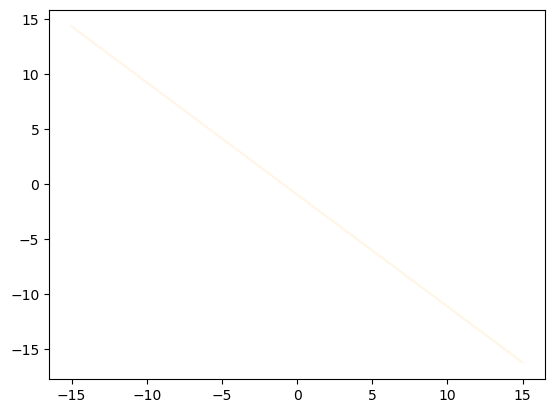

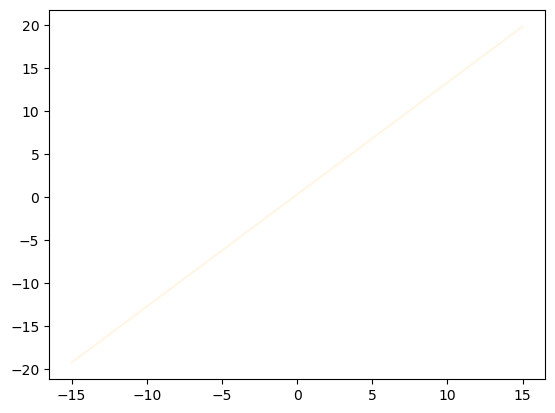

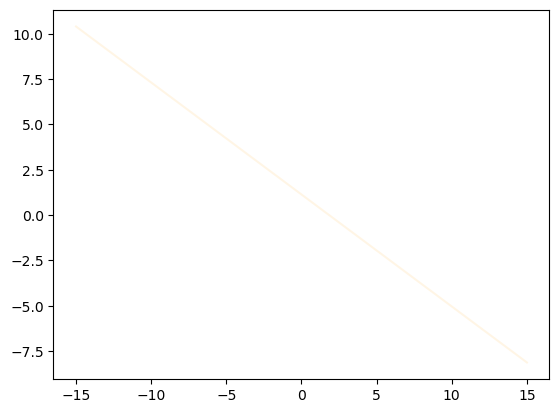

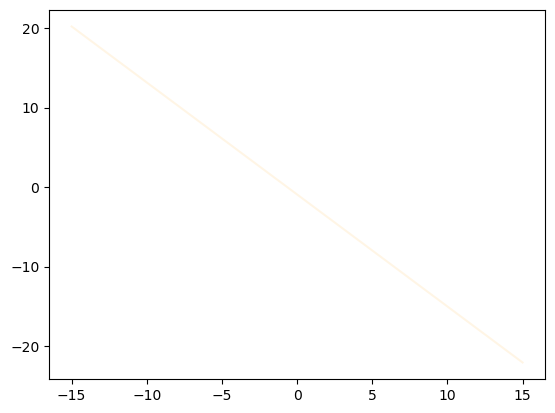

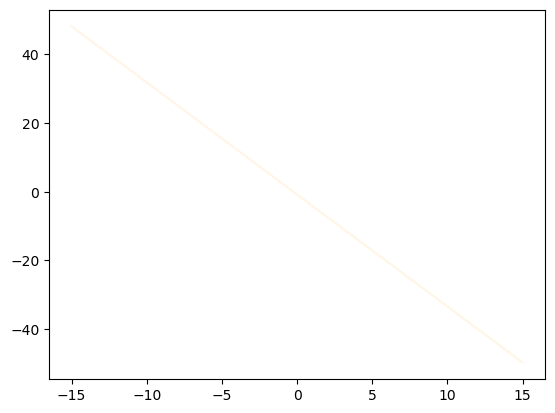

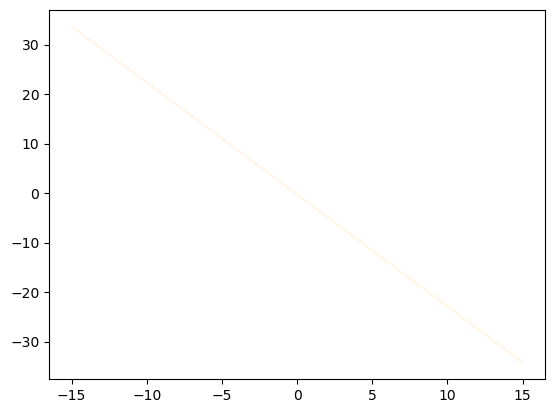

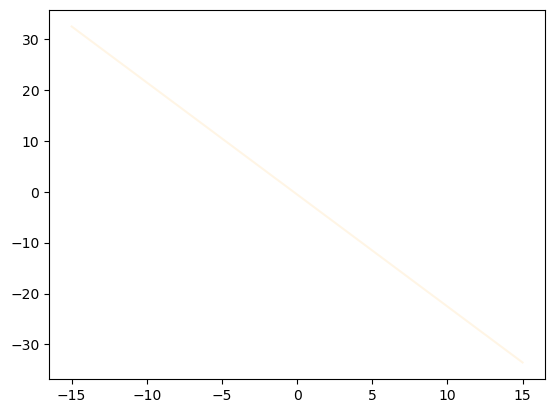

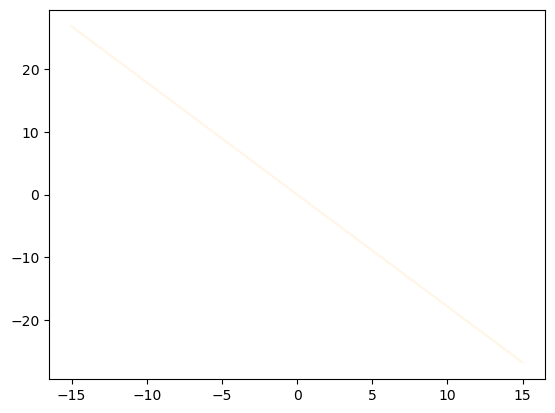

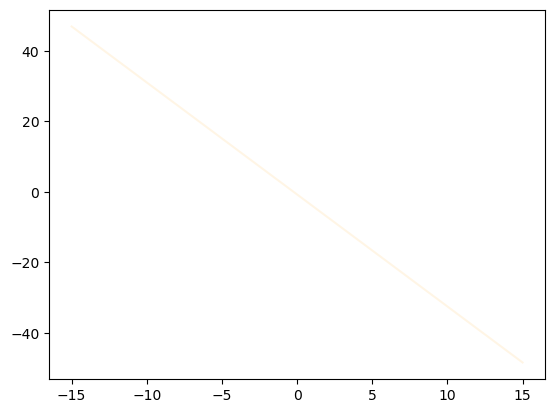

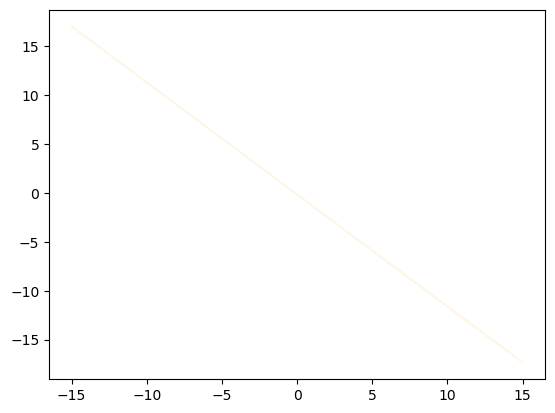

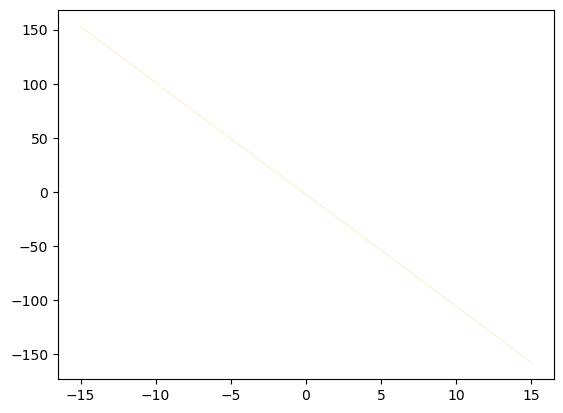

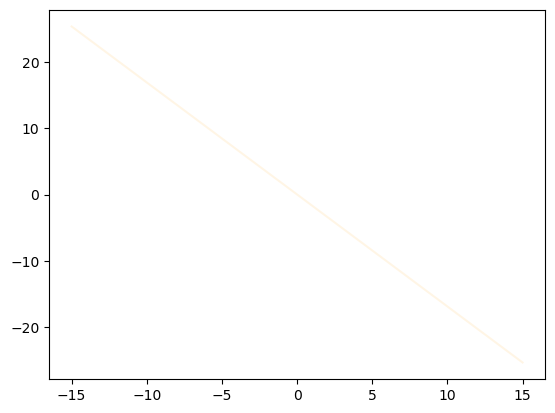

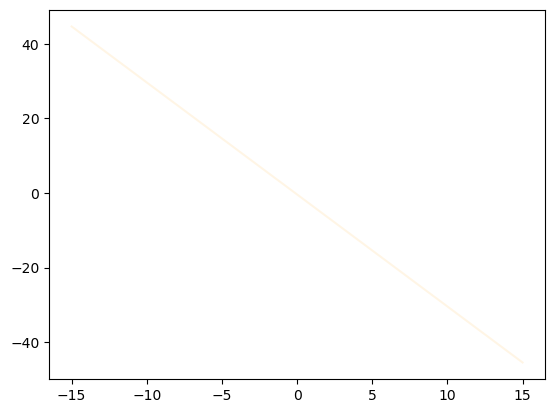

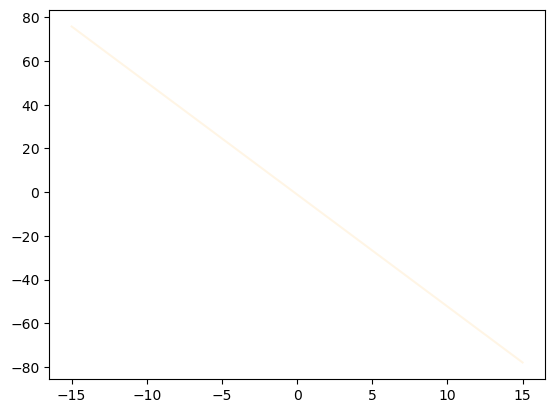

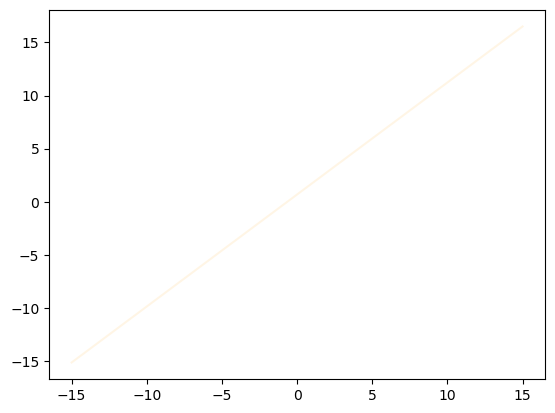

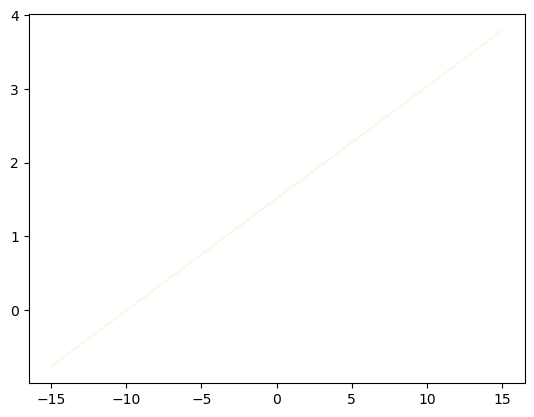

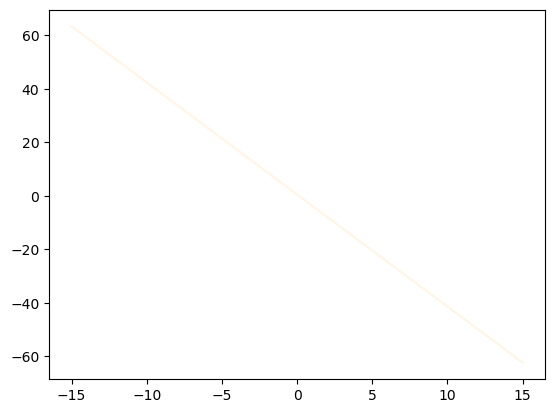

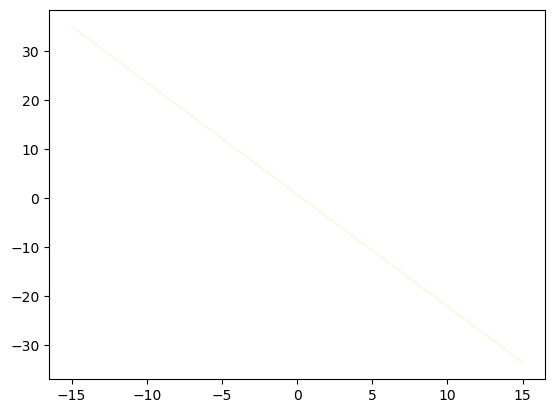

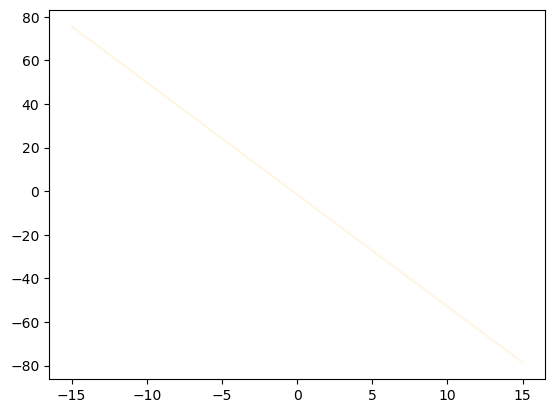

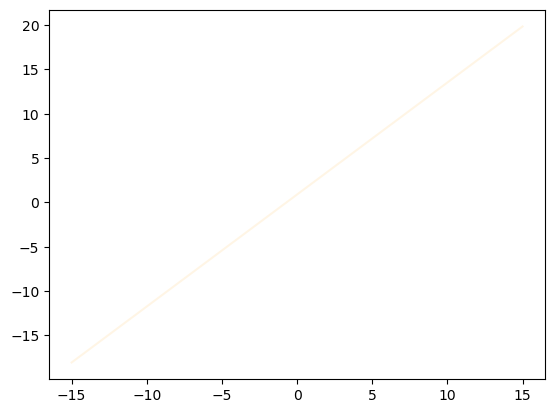

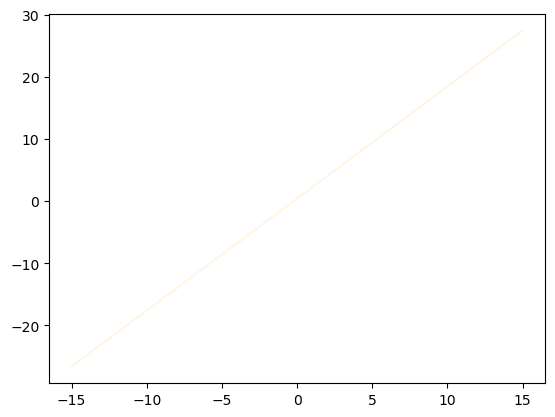

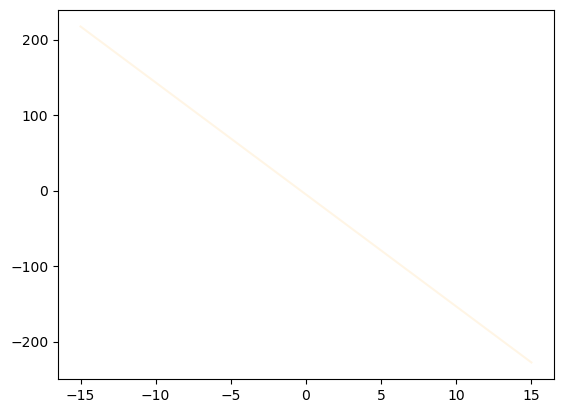

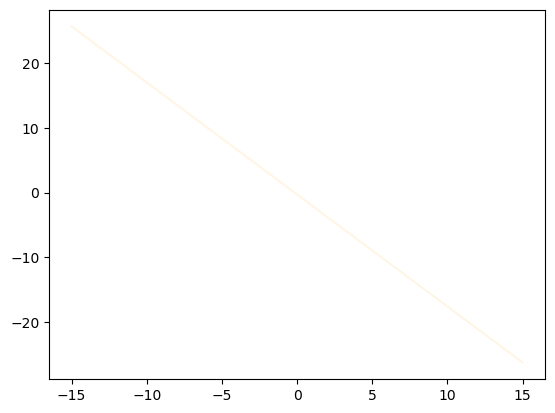

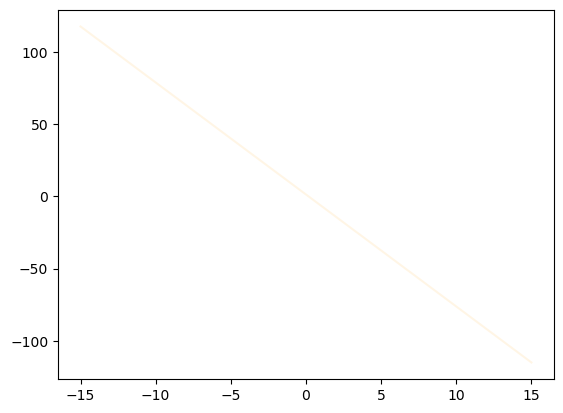

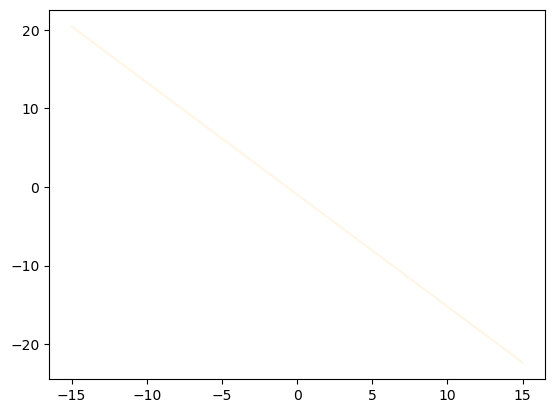

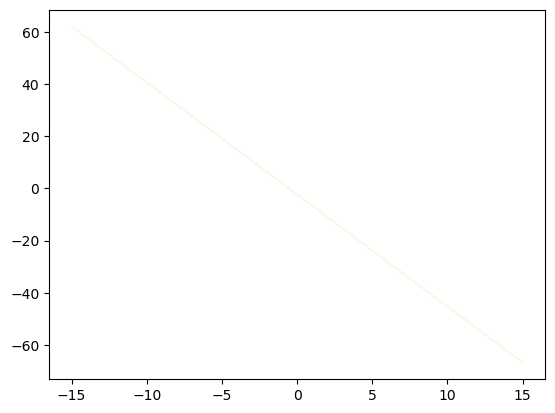

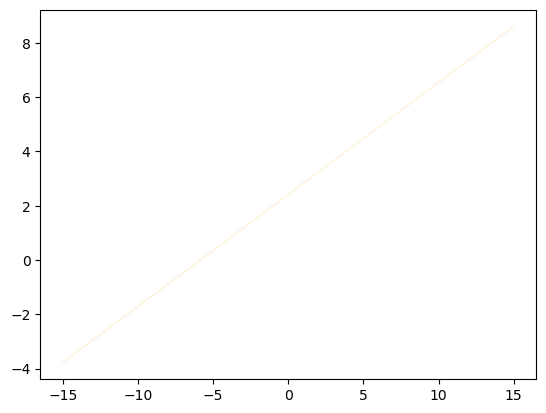

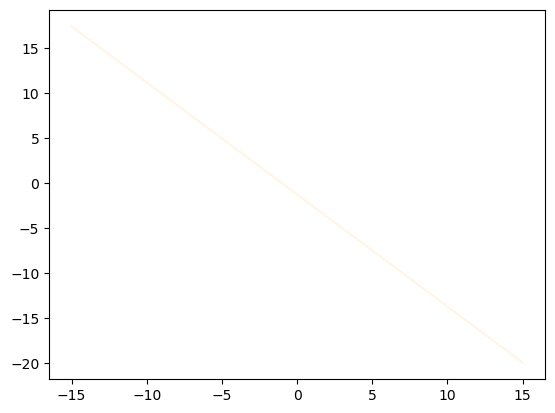

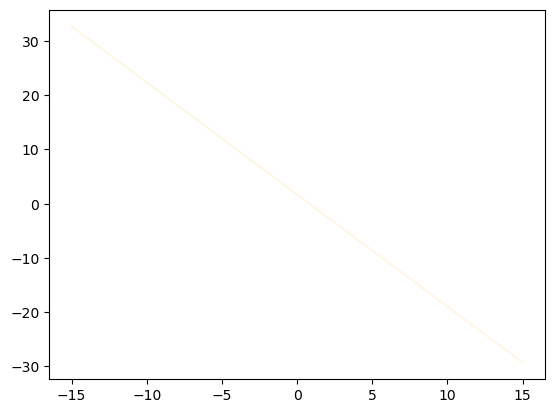

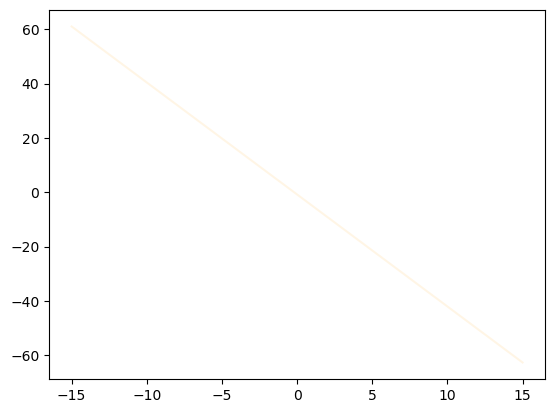

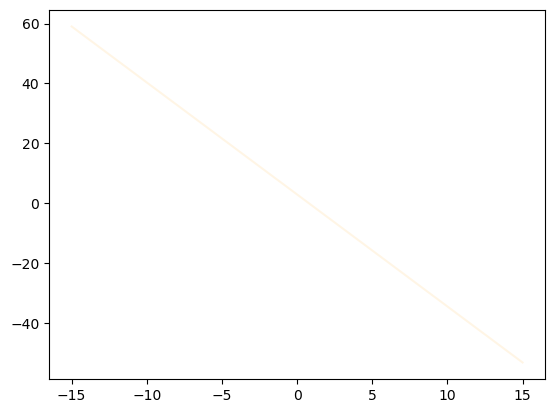

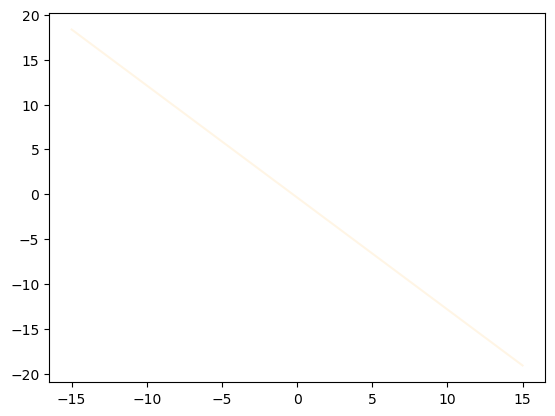

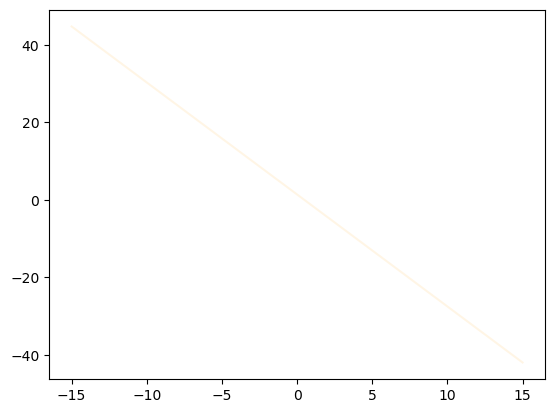

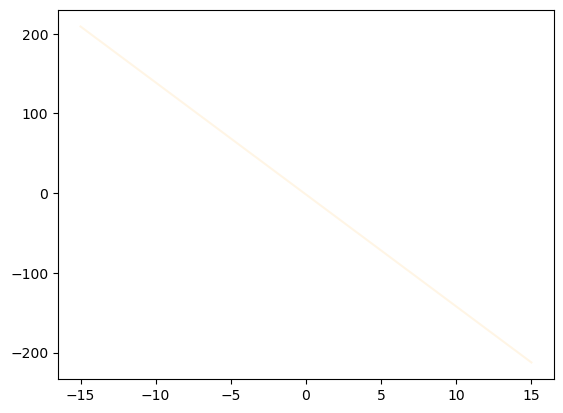

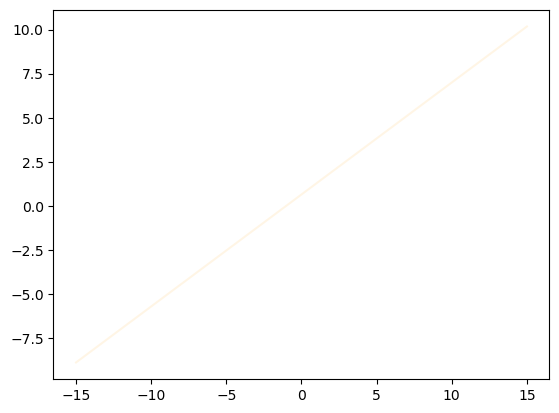

KeyboardInterrupt: 

In [13]:
columns = ["x", "y", "spiral"]
df: pd.DataFrame = load_csv_data(filepath = "../../resources/spiral.csv", columns = columns, transpose = False)
print(df.head())

plot_data(df=df)

data = prepare_data(df = df,
                    input_columns=["x", "y"],
                    target_column="spiral",
                    transpose=True,
                    test_size=0.2,
                    random_state=42)

print(data['X'].shape)
print(data['Y'].shape)

weights = simple_perceptron_train(
                            X_train = data['X'], 
                            Y_train = data['Y'].reshape(1, -1),
                            epochs = 100,
                            learning_rate = 0.1,
                            w_random = True,
                            data_frame = df)

print("Pesos aprendidos:\n", weights)